#Demo de TF-Agents para BlackJack (21) usando primero Q-Learning y luego una red DQN

 Basado en los tutoriales de Tensor Flow: https://www.tensorflow.org/agents/tutorials/2_environments_tutorial

In [51]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'agents' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
TF-Agentes instalado.


In [52]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint

import random
import pandas as pd

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


In [53]:
#@title Definir Entorno del Problema 

# Un entorno que represente el juego podría verse así:
##Acciones: Tenemos dos acciones. 
##             Acción 0: obtener una nueva carta 
##             Acción 1: terminar la ronda actual.
##Observaciones: Suma de las cartas de la ronda actual.
##Recompensa: El objetivo es acercarse lo más posible a 21 sin pasarse, 
##            por lo que podemos lograrlo usando la siguiente recompensa al final de la ronda: 
##            suma_de_tarjetas - 21 si suma_de_tarjetas <= 21, de lo contrario -21

posiblesAccionesDescrip = ["pide carta", "decide no pedir más cartas"]
posiblesEstadosDescrip = ['SUMA={:}'.format(x) for x in range(0, 100)]
posiblesCartas = ['-', 'As', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
class CardGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state, 0], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # Aplica la acción
    if action == 1:
      # indica no seguir jugando
      self._episode_ended = True
      new_card = 0
    elif action == 0:
      # solicita una carta
      new_card = randint(1, 12)
      if new_card == 1:
        # el as puede valer 1 o 11
        if (self._state + 11) < 21:
          self._state = self._state + 11
        else:
          self._state = self._state + 1  
      elif new_card >= 10:
        # las figuras valen 10
        self._state = self._state + 10
      else:
        # el resto vale su valor
        self._state = self._state + new_card
      # se llega a un valor de 21, no se puede pedir más
      if self._state >= 21:
        self._episode_ended = True
    else:
      raise ValueError('La acción debe ser 0 o 1.')

    # finaliza 
    if self._episode_ended:
      # si finaliza
      # determina el reward (siempre se maximiza)
      # en este caso el máximo es 21!
      if self._state > 21:
        # se paso de 21, devuelve cantidad que se paso (negativo)
        reward = 21 - self._state 
      else:
        # no se paso de 21 (devuelve a donde llegó)
        reward = self._state 
      return ts.termination(np.array([self._state, new_card], dtype=np.int32), reward)
    else:
      # si no finaliza
      return ts.transition(
          np.array([self._state, new_card], dtype=np.int32), reward=0.0, discount=0.9)


print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = CardGameEnv()
eval_py_env = CardGameEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")


# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo, num_episodes=1, mostrarDetalleStep=False):
    if num_episodes <=0:
      num_episodes = 1    
    # inicializa acumulador auxiliar 
    cumulative_reward_total = 0.0    
    print("\n** ", titulo, "**")                   
    for i in range(num_episodes):
      if num_episodes>1:
        print("\n> Episodio ", i+1, ": ")
      # muesta estado inicial
      time_step = eval_env.reset()  
      ob = time_step.observation.numpy()[0]
      if mostrarDetalleStep:
        print(" Ini: estado", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")      
      else:
        print(" Ini: estado", posiblesEstadosDescrip[ob[0]])      
      j = 1
      while not time_step.is_last():
        # la política determina la acción a realizar
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        # recupera la observación y muestra el nuevo estado 
        ob = time_step.observation.numpy()[0]
        if ob[1] == 0:
          descAccion = posiblesAccionesDescrip[1]
        else:
          descAccion = posiblesAccionesDescrip[0] + " " + posiblesCartas[ob[1]]
        if mostrarDetalleStep:
          print(" #", j, ":", descAccion, "-> estado:", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
        else:
          print(" #" + str(j) + ":", descAccion, "-> estado:", posiblesEstadosDescrip[ob[0]])
        j = j + 1
        
      # muestra estado final
      ob = time_step.observation.numpy()[0]
      r = time_step.reward.numpy()
      if mostrarDetalleStep:
        print(" Fin -> estado", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
      else:
        print(" Fin -> estado", posiblesEstadosDescrip[ob[0]])
      print(' Recompensa final = ', r[0])
      cumulative_reward_total += r[0]
    if num_episodes > 1:
      promedioEpisodios = round(cumulative_reward_total/num_episodes,3)
      print("\n= Recompensa Promedio Total: ", promedioEpisodios, "\n")
      return promedioEpisodios
    else:
      return cumulative_reward_total


# función auxiliar para comparar
def compararRtdosPolicy(cantidad_probar, eval_env, policy1, policy2, descPol1="Agente 1", descPol2="Agente 2"):
  prom1 = 0
  prom2 = 0
  for i in range(cantidad_probar):
    print("\n> Prueba ", i+1, ":")
    # Probar 1
    valor1 = SimularEntorno(eval_env, policy1, "Resultados de " + descPol1, False) 
    prom1 = prom1 + valor1
    # Probar 2
    valor2 = SimularEntorno(eval_env, policy2, "Resultados de " + descPol2, False) 
    prom2 = prom2 + valor2
    # Decide Ganador
    strMostrar = "\n--> " + descPol1 + " (%s) genera" % valor1
    if valor1 > valor2:
      strMostrar = strMostrar + " MEJOR "
    elif valor1 < valor2:
      strMostrar = strMostrar + " PEOR "
    else:
      strMostrar = strMostrar + " IGUAL "
    strMostrar = strMostrar + "resultado que " + descPol2 + " (%s)." % valor2
    print(strMostrar)
  # Decide Ganador General
  if cantidad_probar > 0:
    prom1 = prom1 / cantidad_probar
    prom2 = prom2 / cantidad_probar
    print("\n================================================================================================\n")
    strMostrar = " * En Promedio " + descPol1 + " (%s) genera" % prom1
    if prom1 > prom2:
      strMostrar = strMostrar + " MEJORES "
    elif prom1 < prom2:
      strMostrar = strMostrar + " PEORES "
    else:
      strMostrar = strMostrar + " IGUALES "
    strMostrar = strMostrar + "resultados que " + descPol2 + " (%s)." % prom2
    print(strMostrar)
    print("\n================================================================================================\n")


print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar", 1, MostarDetalleSteps)


Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: estado SUMA=0
 #1: pide carta 7 -> estado: SUMA=7
 #2: decide no pedir más cartas -> estado: SUMA=7
 Fin -> estado SUMA=7
 Recompensa final =  7.0


##Q-Learning

In [54]:
#@title Define clase auxiliar Policy para Q-Learning

## funciones auxiliares basadas en:
##  https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/


from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.trajectories import policy_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec
from tf_agents.typing import types
from typing import Optional, Text

# Se hereda de FixedPolicy porque es una simple para tener como base
class QL_TF_Policy(FixedPolicy):
    
  def __init__(self,
               posiblesEstadosList, 
               posiblesAccionesList,
               time_step_spec: ts.TimeStep,
               action_spec: types.NestedTensorSpec,
               policy_info: types.NestedTensorSpec = (),
               info_spec: types.NestedTensorSpec = (),
               name: Optional[Text] = None):    
    
      # llama al padre
      super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                      info_spec=info_spec,
                                      name=name,
                                      emit_log_probability=False)             
      # guarda valores auxiliares
      self._policy_info = policy_info
      self._time_step_spec = tensor_spec.from_spec(time_step_spec)
      self._action_spec = tensor_spec.from_spec(action_spec)   
      # inicializa parametros de matriz
      if (posiblesEstadosList is None) or (len(posiblesEstadosList)<2):
       raise ValueError('No se ha definida la lista de posibles estdos!' )
      self._posiblesEstadosList = posiblesEstadosList
      self._cantEstados = len(posiblesEstadosList)
      if (posiblesAccionesList is None) or (len(posiblesAccionesList)<2):
       raise ValueError('No se ha definida la lista de posibles acciones!' )
      self._posiblesAccionesList = posiblesAccionesList
      self._cantAcciones = len(posiblesAccionesList)
      self.ResetQ()
  
  # funcion auxiliar para inicializar la matriz
  def ResetQ(self):     
      self._Qtable = np.zeros([self._cantEstados, self._cantAcciones])

  # función auxiliar de entrenamiento
  def TrainQ(self, env, random_policy, alpha = 0.1, gamma = 0.6, epsilon = 0.1, cant_ciclos_entrenamiento = 100000, log_cada_ciclos = 1000):
      # ejecuta el entrenamiento
      for step in range(1, cant_ciclos_entrenamiento+1):
          # Resetea el enviroment
          time_step = env.reset()  
          ob = time_step.observation.numpy()[0]
          state = ob[0] 
          secuenciaAcciones = ""
          j = 1
          # Simula      
          while not time_step.is_last():
              # Considera lo aprendido o toma al azar depende de azar y epsilon
              if random.uniform(0, 1) < epsilon:
                  # toma al azar
                  action_step = random_policy.action( time_step )
                  accionAplicar = action_step.action.numpy()[0]
              else:
                  # toma de Matriz-Q
                  accionAplicar = np.argmax( self._Qtable[state] )
              if j > 1:
                secuenciaAcciones = secuenciaAcciones + " + "
              secuenciaAcciones = secuenciaAcciones + self._posiblesAccionesList[ accionAplicar ]	
              j = j + 1
              # Aplica la Accion    
              time_step = env.step( accionAplicar )
              ob = time_step.observation.numpy()[0]
              next_state = ob[0]   
              r = time_step.reward.numpy()[0] 
              # Recalcula Q
              q_value = self._Qtable[state, accionAplicar]
              max_value = np.max(self._Qtable[next_state])
              new_q_value = (1 - alpha) * q_value + alpha * (r + gamma * max_value)                       
              # Actualiza Matriz-Q
              self._Qtable[state, accionAplicar] = new_q_value
              state = next_state        
          # muestra estado
          if log_cada_ciclos > 0:
            if (step == 1) or (step % log_cada_ciclos == 0):
              print('step = {0}: Recompensa = {1} - Acciones({2}) = {3} '.format(step, r, (j-1), secuenciaAcciones))  
      # Devuelve Matriz-Q
      return self._Qtable   


  # función auxiliar para mostrar matri Q
  def MostrarQ(self):
        # muestra Q table
        print('\n Matriz-Q entrenada: ')
        cm = self._Qtable 
        cmtx = pd.DataFrame(
            cm, 
            index=self._posiblesEstadosList, 
            columns=self._posiblesAccionesList
          )
        # agrega para poder mostrar la matrix de confusión completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmtx)
        print("\n")


  # devuelve la accion que se debe aplicar usando la matrix Q entrenada
  def _action(self, time_step, policy_state, seed):    
      # determina la accion a realizar
      # obtiene estado actual
      ob = time_step.observation.numpy()[0]
      state = ob[0] 
      # toma de Matriz-Q      
      accionAplicar = np.argmax( self._Qtable[state] )
      # formatea el valor a devolver usando la action_spec y time_step_spec
      def convert(action, spec):
        return tf.convert_to_tensor(value=action, dtype=spec.dtype)
      self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                  self._action_spec)
      outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
      action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                   self._action_value)
      # devuelve la accion
      return policy_step.PolicyStep(action, policy_state, self._policy_info)


print("Clase QL_TF_Policy creada.")

Clase QL_TF_Policy creada.


In [55]:
#@title Entrenar con algoritmo Q-Learning

# parámetros
alpha = 0.1 #@param {type:"number"}
gamma = 0.6 #@param {type:"number"}
epsilon = 0.5 #@param {type:"number"}
cant_ciclos_entrenamiento = 5000 #@param {type:"integer"}
log_cada_ciclos = 200  #@param {type:"integer"}
if alpha <= 0.0:
   alpha = 0.001
if gamma <= 0.0:
    gamma = 0.001
if epsilon <= 0.0:
   epsilon = 0.001    
if cant_ciclos_entrenamiento <= 10:
   cant_ciclos_entrenamiento = 10    


# instancia política de Q Learning
ql_policy = QL_TF_Policy(posiblesEstadosDescrip,
                         posiblesAccionesDescrip,
                         train_env.time_step_spec(),
                         train_env.action_spec())

# hace el entrenamiento
print("** Comienza el Entrenamiento:\n")
ql_policy.TrainQ(train_env, random_policy, 
                 alpha, gamma, epsilon, 
                 cant_ciclos_entrenamiento, 
                 log_cada_ciclos)
print("\n** Entrenamiento Finalizado **")
# muestra matriz
ql_policy.MostrarQ()


** Comienza el Entrenamiento:

step = 1: Recompensa = 9.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 200: Recompensa = 6.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 400: Recompensa = 3.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 600: Recompensa = 0.0 - Acciones(1) = decide no pedir más cartas 
step = 800: Recompensa = 9.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 1000: Recompensa = 0.0 - Acciones(1) = decide no pedir más cartas 
step = 1200: Recompensa = 0.0 - Acciones(1) = decide no pedir más cartas 
step = 1400: Recompensa = 10.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 1600: Recompensa = 21.0 - Acciones(2) = pide carta + pide carta 
step = 1800: Recompensa = 17.0 - Acciones(4) = pide carta + pide carta + pide carta + decide no pedir más cartas 
step = 2000: Recompensa = 5.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 2200: Recompensa = 8.0 - Acciones(3) =

In [56]:
#@title Probar Q-Learning Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ql_policy, random_policy, "Agente Q-Learning entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: estado SUMA=0
 #1: pide carta 9 -> estado: SUMA=9
 #2: pide carta 5 -> estado: SUMA=14
 #3: decide no pedir más cartas -> estado: SUMA=14
 Fin -> estado SUMA=14
 Recompensa final =  14.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 7 -> estado: SUMA=7
 #2: pide carta 4 -> estado: SUMA=11
 #3: decide no pedir más cartas -> estado: SUMA=11
 Fin -> estado SUMA=11
 Recompensa final =  11.0

--> Agente Q-Learning entrenado (14.0) genera MEJOR resultado que el Azar (11.0).

> Prueba  2 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: estado SUMA=0
 #1: pide carta Q -> estado: SUMA=10
 #2: decide no pedir más cartas -> estado: SUMA=10
 Fin -> estado SUMA=10
 Recompensa final =  10.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 2 -> estado: SUMA=2
 #2: decide no pedir más cartas -> estado: SUMA=2
 Fin -> estado SUMA=2
 Recompensa final =  2.0

--> Agente Q-Learning entrenad

##DQN

In [57]:
#@title Definir el Agente tipo DQN

learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = 100 # @param {type:"integer"}
if cant_neuronas_ocultas < 10:
  cant_neuronas_ocultas = 10

# Define cantidad de neuronas ocultas para RNA-Q
fc_layer_params = (cant_neuronas_ocultas,)

# Define RNA-Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# Define el agente de tipo Q
ag = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

ag.initialize()

# define política para evaluación para el Agente
eval_policy = ag.policy

# define política para recolección de datos para el Agente
collect_policy = ag.collect_policy

print("Agente DQN inicializado. ")

Agente DQN inicializado. 


In [58]:
#@title Definir Métricas para evaluación para Agente DQN

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


In [59]:
#@title Preparar datos para Entrenamiento del Agente DQN

initial_collect_steps = 500  # @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}


# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

# Preparar los datos recolectados con trajectories de shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)
# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.

Dataset creado.


In [60]:
#@title Entrenar al Agente DQN

cant_ciclos_entrenamiento = 5000 # @param {type:"integer"}
log_cada_ciclos = 200  # @param {type:"integer"}
evaluar_cada_ciclos = 1000  # @param {type:"integer"}
cant_episodios_evaluacion = 25  # @param {type:"integer"}


#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step % evaluar_cada_ciclos == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

step = 1: loss = 16.464
step = 1: Promedio Recompensa = 0.0
step = 200: loss = 27.027
step = 400: loss = 26.450
step = 600: loss = 6.754
step = 800: loss = 3.047
step = 1000: loss = 4.769
step = 1000: Promedio Recompensa = 13.8
step = 1200: loss = 2.901
step = 1400: loss = 3.396
step = 1600: loss = 15.327
step = 1800: loss = 1.660
step = 2000: loss = 2.971
step = 2000: Promedio Recompensa = 14.4
step = 2200: loss = 5.358
step = 2400: loss = 2.544
step = 2600: loss = 1.968
step = 2800: loss = 2.479
step = 3000: loss = 9.843
step = 3000: Promedio Recompensa = 14.6
step = 3200: loss = 1.566
step = 3400: loss = 10.774
step = 3600: loss = 1.737
step = 3800: loss = 7.531
step = 4000: loss = 5.889
step = 4000: Promedio Recompensa = 14.2
step = 4200: loss = 2.662
step = 4400: loss = 8.489
step = 4600: loss = 5.278
step = 4800: loss = 4.501
step = 5000: loss = 4.666
step = 5000: Promedio Recompensa = 15.2

** Entrenamiento Finalizado **



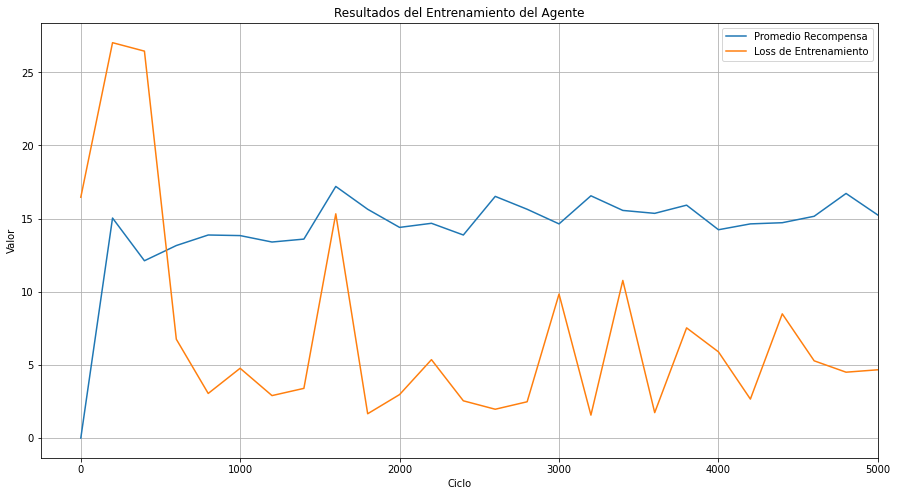

In [61]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN

plt.figure(figsize=(15,8)) 
plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss )
plt.title("Resultados del Entrenamiento del Agente")
plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
##plt.ylim(top=21)    
plt.grid(True)
plt.show()


In [62]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ag.policy, random_policy, "Agente DQN entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente DQN entrenado **
 Ini: estado SUMA=0
 #1: pide carta 4 -> estado: SUMA=4
 #2: pide carta 6 -> estado: SUMA=10
 #3: decide no pedir más cartas -> estado: SUMA=10
 Fin -> estado SUMA=10
 Recompensa final =  10.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 10 -> estado: SUMA=10
 #2: decide no pedir más cartas -> estado: SUMA=10
 Fin -> estado SUMA=10
 Recompensa final =  10.0

--> Agente DQN entrenado (10.0) genera IGUAL resultado que el Azar (10.0).

> Prueba  2 :

**  Resultados de Agente DQN entrenado **
 Ini: estado SUMA=0
 #1: pide carta 3 -> estado: SUMA=3
 #2: pide carta 7 -> estado: SUMA=10
 #3: pide carta 8 -> estado: SUMA=18
 #4: decide no pedir más cartas -> estado: SUMA=18
 Fin -> estado SUMA=18
 Recompensa final =  18.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 7 -> estado: SUMA=7
 #2: decide no pedir más cartas -> estado: SUMA=7
 Fin -> estado SUMA=7
 Recompensa final =  7.0

--> Agente DQ

## Comparar Q-Learning y DQN

In [63]:
#@title Probar Q-Learning Entrenado contra Agente DQN Entrenado
cantidad_probar = 10 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ag.policy, ql_policy, "Agente DQN", "Agente Q-Learning")



> Prueba  1 :

**  Resultados de Agente DQN **
 Ini: estado SUMA=0
 #1: pide carta 9 -> estado: SUMA=9
 #2: pide carta Q -> estado: SUMA=19
 #3: decide no pedir más cartas -> estado: SUMA=19
 Fin -> estado SUMA=19
 Recompensa final =  19.0

**  Resultados de Agente Q-Learning **
 Ini: estado SUMA=0
 #1: pide carta 8 -> estado: SUMA=8
 #2: decide no pedir más cartas -> estado: SUMA=8
 Fin -> estado SUMA=8
 Recompensa final =  8.0

--> Agente DQN (19.0) genera MEJOR resultado que Agente Q-Learning (8.0).

> Prueba  2 :

**  Resultados de Agente DQN **
 Ini: estado SUMA=0
 #1: pide carta 5 -> estado: SUMA=5
 #2: pide carta J -> estado: SUMA=15
 #3: decide no pedir más cartas -> estado: SUMA=15
 Fin -> estado SUMA=15
 Recompensa final =  15.0

**  Resultados de Agente Q-Learning **
 Ini: estado SUMA=0
 #1: pide carta 3 -> estado: SUMA=3
 #2: pide carta 2 -> estado: SUMA=5
 #3: pide carta 3 -> estado: SUMA=8
 #4: decide no pedir más cartas -> estado: SUMA=8
 Fin -> estado SUMA=8
 Recompens

In [64]:
#@title Probar Agentes entrenados contra Usuario Humano 
#@markdown (notar que agentes no conocen las cartas que salieron al otro)
import ipywidgets as widgets
from IPython.display import display, clear_output

def resetear():
  global agentesDescrip, envAgentes, nroPasoAgentes, TSAgentes
  # Inicializar variables
  envAgentes = []
  nroPasoAgentes = []
  TSAgentes = []
  # Crea los entornos e inicializa variables
  for i in range(len(agentesDescrip)):
    env = tf_py_environment.TFPyEnvironment( CardGameEnv() )
    ts = env.reset()  
    #ob = time_step.observation.numpy()[0]    
    envAgentes.append( env )
    nroPasoAgentes.append( 1 )
    TSAgentes.append( ts )

def jugar(prefijoJugador, nombreJugador, env, paso, action):
  if paso < 0:
    # no se hace porque ya termino la partida
    return paso
  else:
    # aplica la acción
    time_step = env.step(action)
    # recupera la observación y muestra el nuevo estado 
    ob = time_step.observation.numpy()[0]
    if ob[1] == 0:
      descAccion = posiblesAccionesDescrip[1]
    else:
      descAccion =posiblesAccionesDescrip[0] + " " + posiblesCartas[ ob[1] ]
    print(prefijoJugador, "Juega", nombreJugador, "#" + str(paso) + ":", descAccion, "->", posiblesEstadosDescrip[ob[0]] )
    # ve si termino o sigue
    if time_step.is_last():
      paso = -1
    else:
      paso = paso + 1
    return paso, time_step

def jugarAgentes():
    global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
    algunoPuedeSeguirJugando = False
    # inicia jugando primero a los agentes
    for i in range(len(agentesPolicy)):
      # no es humano
      if i != idPosHumano:
        # puede seguir jugando
        if nroPasoAgentes[i] >= 0:
          aux_action_step  = agentesPolicy[i].action( TSAgentes[i] )
          auxPaso, auxTS = jugar("*", agentesDescrip[i], envAgentes[i], nroPasoAgentes[i], aux_action_step.action)
          nroPasoAgentes[i] = auxPaso
          TSAgentes[i] = auxTS
          algunoPuedeSeguirJugando = algunoPuedeSeguirJugando or (auxPaso >= 0)
    return algunoPuedeSeguirJugando

# define funciones para los botones
def on_buttonR_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón para reiniciar la partida
  with output:
    clear_output()
    print("\n> Nueva Partida:\n")
    # resetea ambientes
    resetear()
    # inicia jugando primero a los agentes
    jugarAgentes()
    # fuerza que le de la primera carta al humano
    on_button0_clicked(button0)
  # muestra botones
  display(button0, button1, buttonR, output)

def on_button0_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón de pedir nueva carta
  with output:
    # juega humano
    if nroPasoAgentes[idPosHumano] >= 0:
      auxPaso, auxTS = jugar("+", agentesDescrip[idPosHumano], envAgentes[idPosHumano], nroPasoAgentes[idPosHumano], np.array(0, dtype=np.int32))
      nroPasoAgentes[idPosHumano] = auxPaso
      TSAgentes[idPosHumano] = auxTS
    print(" ")
    # juega agentes 
    puedenAGSeguir = True
    while puedenAGSeguir:
      puedenAGSeguir = jugarAgentes()
      if nroPasoAgentes[idPosHumano] >= 0:
        # si el humano no terminó, lo hace jugar una vez solamente
        break
    # si todos finalizaron, muestra el estado final
    if not(puedenAGSeguir) and (nroPasoAgentes[idPosHumano] < 0):
      mostrarEstadoFinal()

def on_button1_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón de finalizar partida (plantarse)
  with output:
    # juega humano
    if nroPasoAgentes[idPosHumano] >= 0:
      auxPaso, auxTS = jugar("+", agentesDescrip[idPosHumano], envAgentes[idPosHumano], nroPasoAgentes[idPosHumano], np.array(1, dtype=np.int32))
      nroPasoAgentes[idPosHumano] = auxPaso
      TSAgentes[idPosHumano] = auxTS
    print(" ")
    # juega agentes hasta que terminen
    puedenAGSeguir = True
    while puedenAGSeguir:
      puedenAGSeguir = jugarAgentes()
    # muesta el estado final
    mostrarEstadoFinal()
    print("\n")

def mostrarEstadoFinal():
    global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes        
    # muestra estado final
    print("\n> Resultados: ")
    rewL = []
    for i in range(len(agentesDescrip)):
      r = int( TSAgentes[i].reward.numpy()[0] )
      rewL.append( r )
      resul = "%s" % r
      if (r > 21) or (r < 0):
        resul = resul + "!"
      print("\t " + agentesDescrip[i] + ": " + resul)
    print("\t = GANA: "  + agentesDescrip[ np.argmax(rewL) ])  
    print("\n")
    return


# inicializa variables auxiliares
idPosHumano = 2
agentesDescrip = ["Agente QL", "Agente DQN", "Humano"]
agentesPolicy = [ql_policy, ag.policy, None]
resetear()

# define botones
button0 = widgets.Button(description="Dame Otra Carta")
button1 = widgets.Button(description="Plantarse")
buttonR = widgets.Button(description="Reiniciar Partida")
output = widgets.Output()
buttonR.on_click(on_buttonR_clicked)
button1.on_click(on_button1_clicked)
button0.on_click(on_button0_clicked)    

# comienza a jugar
on_buttonR_clicked(buttonR)



Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()

Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()

Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()